In [13]:
import netCDF4 as nc
from netCDF4 import Dataset

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import xarray as xr

from scipy import signal
from scipy import stats

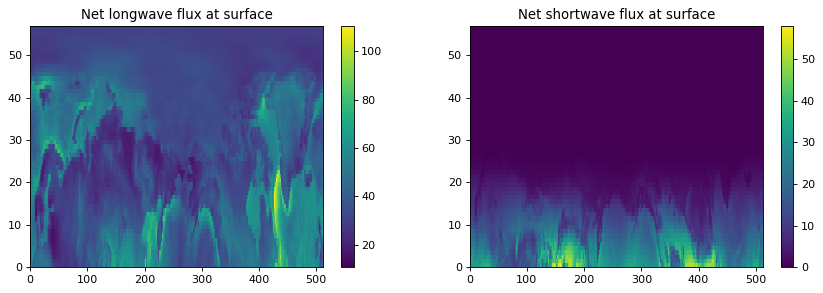

In [2]:
# directory paths
atmdir = "/global/project/projectdirs/m1199/iHESP/Atmosphere/"
ocndir = "/global/project/projectdirs/m1199/iHESP/Ocean/"

# in:    t (1 to 50) 
# out:   string corresponding to date range 
def getTimeRange(t):
    initial = (t + 1) * 1000 + 1 if t != 1 else (t + 1) * 1000 + 101
    final = (t + 1) * 1000 + 912
    return "00" + str(initial) + "-00" + str(final) if initial < 10000 else "0" + str(initial) + "-0" + str(final)

# in:    var (str)
#        directory (atmdir or ocndir)
#        t (1 to 50) corresponding to decade
#        getDataset 
#        nhemisphere 
# out:   data

# todo: add option to revert back to full spatial dataset

def getData(var, directory, t, getDataset=False, nhemisphere=True):
    filename = "B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.cam.h0."+var+"."+getTimeRange(1)+".gr.nc"
    data = xr.open_dataset(directory+var+"/"+filename).variables[var][:,200:,:] 
    if t == "all":
        for i in range(49):
            filename = "B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.cam.h0."+var+"."+getTimeRange(i+1)+".gr.nc"
            # append to time axis
            data = np.append(data, xr.open_dataset(directory+var+"/"+filename).variables[var][:,200:,:], axis=0)
        return data if getDataset else data.va
    else: 
        filename = "B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.cam.h0."+var+"."+getTimeRange(t)+".gr.nc"
        data = xr.open_dataset(directory+var+"/"+filename)
    
        return data if getDataset else data.variables[var][:,200:,:]

# plot some figures 
flns = getData("FLNS", atmdir, 1)
figure(figsize=(13, 4), dpi=80)

plt.subplot(1,2,1)
plt.pcolormesh(flns[0,:,:])
plt.title('Net longwave flux at surface')
plt.colorbar()

fsns = getData("FSNS", atmdir, 1)

plt.subplot(1,2,2)
plt.pcolormesh(fsns[0,:,:])
plt.title('Net shortwave flux at surface')
plt.colorbar()

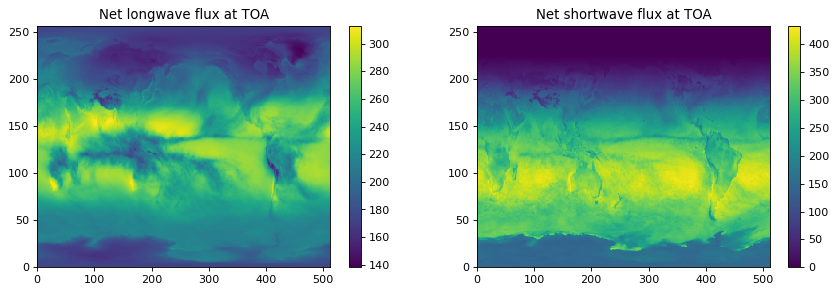

In [4]:
# sign convention: 
# positive longwave is net upwards 
# positive shortwave is net downwards 

flnt = getData("FLNT", atmdir, 1)
fsnt = getData("FSNT", atmdir, 1)

figure(figsize=(13, 4), dpi=80)

plt.subplot(1,2,1)
plt.pcolormesh(flnt[0,:,:])
plt.title('Net longwave flux at TOA')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(fsnt[0,:,:])
plt.title('Net shortwave flux at TOA')
plt.colorbar()

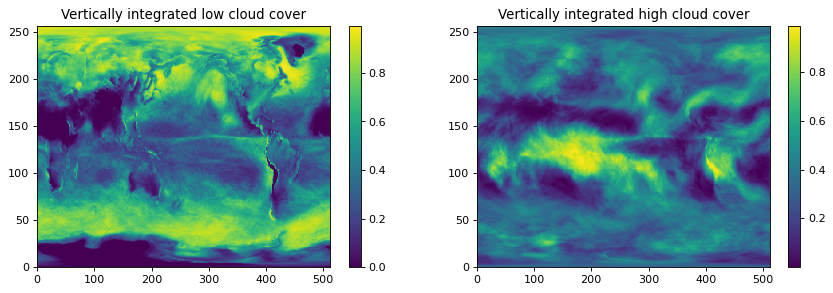

In [5]:
cldlow = getData("CLDLOW", atmdir, 1)
cldhgh = getData("CLDHGH", atmdir, 1)

figure(figsize=(13, 4), dpi=80)

plt.subplot(1,2,1)
plt.pcolormesh(cldlow[0,:,:])
plt.title('Vertically integrated low cloud cover')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(cldhgh[0,:,:])
plt.title('Vertically integrated high cloud cover')
plt.colorbar()


## Calculate total heat flux
Here we estimate the total heat flux at the surface and TOA. We add a correction for the latent heat flux due to snowfall as such:

$F_{snow} = \rho_w \Delta H_{fus} (P_{sc} + P_{sl})$

where $P_{sc}$ and $P_{sl}$ are the convective and large-scale snowfall rates respectively (units m/s)

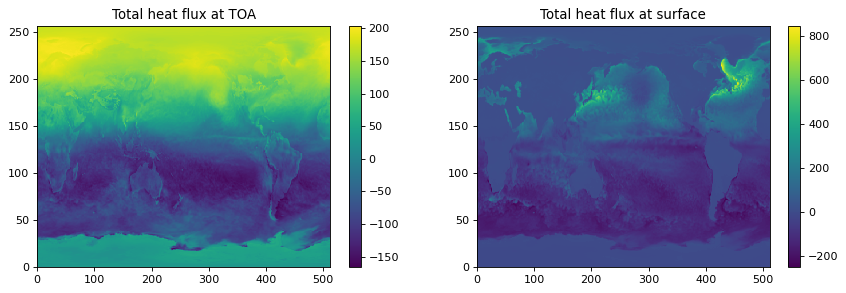

In [6]:
# latent and sensible heat flux
# up is positive (both)
lhfs = getData("LHFLX", atmdir, 1)
shfs = getData("SHFLX", atmdir, 1)

# get snowfall rate 
precsc = getData("PRECSC", atmdir, 1)
precsl = getData("PRECSL", atmdir, 1) 

# calculate the latent heat flux due to snowfall
# rho_w * L_w * (snow rate)
# positive is up
hflxsnow = 1000 * 334000 * (precsc + precsl)

# total fluxes (up is positive)  
fnt = flnt - fsnt 
fns = flns - fsns + lhfs + shfs + hflxsnow

figure(figsize=(13, 4), dpi=80)

plt.subplot(1,2,1)
plt.pcolormesh(fnt[0,:,:])
plt.title('Total heat flux at TOA')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(fns[0,:,:])
plt.title('Total heat flux at surface')
plt.colorbar()

Above: total heat fluxes at TOA and surface for Northern winter (January) 

To do: 
- integrate from north (done)
    - there remains a residual because np.cumsum starts from the first value and the zonally integrated flux divergence at the north pole is not zero
   

In [6]:
# get entire timeseries of fluxes to calculate AHT timeseries 
flnt = getData("FLNT", atmdir, "all")
fsnt = getData("FSNT", atmdir, "all")

flns = getData("FLNS", atmdir, "all")
fsns = getData("FSNS", atmdir, "all")

lhfs = getData("LHFLX", atmdir, "all")
shfs = getData("SHFLX", atmdir, "all")

# get snowfall rate 
precsc = getData("PRECSC", atmdir, "all")
precsl = getData("PRECSL", atmdir, "all") 

# calculate the latent heat flux due to snowfall
# rho_w * L_w * (snow rate)
# positive is up
hflxsnow = 1000 * 334000 * (precsc + precsl)

# total fluxes (up is positive)  
fnt = flnt - fsnt 
fns = flns - fsns + lhfs + shfs + hflxsnow

# get lat lon grid 
lat = getData("FLNT", atmdir, 1, getDataset=True).variables["lat"]
lon = getData("FLNT", atmdir, 1, getDataset=True).variables["lon"]
area = getData("FLNT", atmdir, 1, getDataset=True).variables["area"] # solid angle subtended by gridcell

nlat = lat.size
nlon = lon.size

a = 6.3781e6     # radius of the earth in m

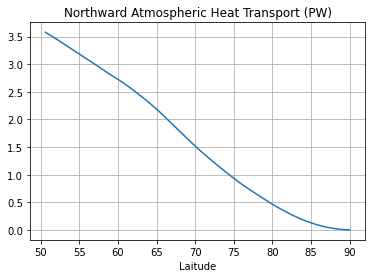

In [37]:
# find the area integrated net flux for each grid cell
fint = (fnt - fns) * area[200:,:].to_numpy() * a**2

fxint = fint.sum(axis=2) # integrate zonally 

aht = np.flip(np.cumsum(np.flip(fxint, axis=1), axis=1), axis=1) # integrate meridionally 

## OHT and AHT

Some notes regarding OHT and AHT: 
- The AHT timeseries in AHT.npy was calculated for only north of 50 deg N
- The OHT timeseries is stored in N_HEAT, which has four fields: time, transport_basin, transport_component, lat 
    - OHT timeseries starts at 0278-01 and ends at 0501-12
    - transport_basin 0: global ocean - marginal seas; 1: Atlantic Ocean + Mediterranean Sea + Labrador Sea + GIN Sea + Arctic Ocean + Hudson Bay + Baltic
    - transport_component 0: Total; 1: Mean; 2: Eddy
    - lat: 347 = 65.06 deg N

(-0.05769153885174625, 0.003449474384972772)


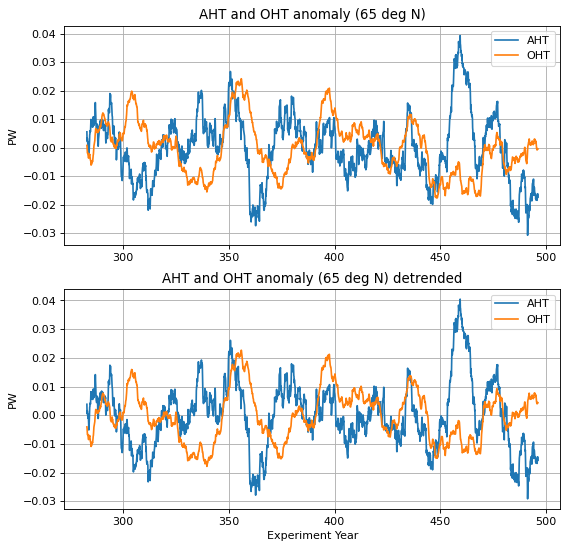

In [25]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# get AHT timeseries at 65 deg N (lat index y = 221, equiv y = 21)
yr_start = 278
yr_end = 501

t_index_start = (yr_start - 21) * 12 
t_index_end = (yr_end - 21) * 12 + 11

movmean_interval = 120

years = np.linspace(yr_start + movmean_interval/24, yr_end - movmean_interval/24, 
                    t_index_end - t_index_start - movmean_interval + 1) 
aht = np.load("AHT.npy")
aht_movmean = running_mean(aht[t_index_start:t_index_end,21], movmean_interval)/1e15

# get the OHT timeseries at 65 deg N
n_heat = xr.open_dataset(ocndir+"N_HEAT/"+"B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.N_HEAT.027801.050112.nc")
oht = n_heat.variables['N_HEAT']
oht_movmean = running_mean(oht[1:,0,0,347], movmean_interval)
oht_movmean2 = running_mean(oht[1:,1,0,347], movmean_interval)


figure(figsize=(8, 8), dpi=80)

plt.subplot(2,1,1)
plt.plot(years, signal.detrend(aht_movmean,type='constant'), label = "AHT")
plt.plot(years, signal.detrend(oht_movmean,type='constant'), label = "OHT")
plt.grid(True)
plt.title("AHT and OHT anomaly (65 deg N)")
plt.ylabel("PW")
plt.legend()

plt.subplot(2,1,2)
plt.plot(years, signal.detrend(aht_movmean), label = "AHT")
plt.plot(years, signal.detrend(oht_movmean), label = "OHT")
plt.grid(True)
plt.title("AHT and OHT anomaly (65 deg N) detrended")
plt.xlabel("Experiment Year")
plt.ylabel("PW")
plt.legend()

print(stats.pearsonr(signal.detrend(aht_movmean),signal.detrend(oht_movmean)))

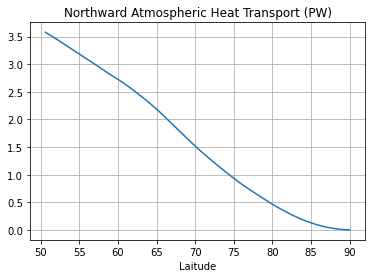

In [29]:
# get lat lon grid 
lat = getData("FLNT", atmdir, 1, getDataset=True).variables["lat"]
lon = getData("FLNT", atmdir, 1, getDataset=True).variables["lon"]
area = getData("FLNT", atmdir, 1, getDataset=True).variables["area"] # solid angle subtended by gridcell

nlat = lat.size
nlon = lon.size

# plot the average for the first nine years 
plt.plot(lat[200:], np.mean(aht[0:107,:], axis=0)/1e15)
plt.title("Northward Atmospheric Heat Transport (PW)")
plt.xlabel("Laitude")
plt.grid(True)

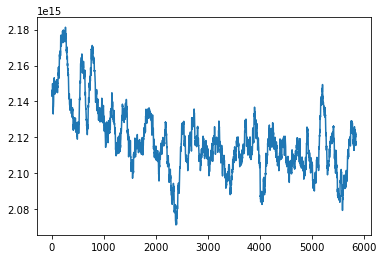

In [32]:
plt.plot(running_mean(aht[:,21], 120))